In [25]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from gensim.models import Word2Vec, FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text
import matplotlib.pyplot as plt

# Загрузка AG News
dataset = load_dataset("ag_news")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

# Тексты и метки (классы 0-3)
X_train = train_df["text"].values
y_train = train_df["label"].values
X_test = test_df["text"].values
y_test = test_df["label"].values

In [20]:
# Векторизация текстов
tfidf = TfidfVectorizer(max_features=15000, stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Обучение модели
lr = LogisticRegression(max_iter=500, n_jobs=-1)
lr.fit(X_train_tfidf, y_train)

# Оценка
y_pred_tfidf = lr.predict(X_test_tfidf)
print("TF-IDF + Logistic Regression:")
print(classification_report(y_test, y_pred_tfidf, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

TF-IDF + Logistic Regression:
              precision    recall  f1-score   support

       World       0.93      0.90      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.88      0.88      0.88      1900
    Sci/Tech       0.89      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [21]:
score = f1_score(y_test, y_pred_tfidf, average='macro')
print(f"F1_macroScore = {score}")

F1_macroScore = 0.9144246384732445


In [28]:
# Токенизация текстов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Паддинг до одинаковой длины
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Обучение Word2Vec
sentences = [text.split() for text in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=3, workers=4)

# Матрица эмбеддингов
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Модель LSTM
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(128),
    Dense(4, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Обучение
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Оценка
y_pred_w2v = model.predict(X_test_pad).argmax(axis=1)
print("\nWord2Vec + LSTM:")
print(classification_report(y_test, y_pred_w2v, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.8222 - loss: 0.5013 - val_accuracy: 0.8602 - val_loss: 0.3833
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 76s 45ms/step - accuracy: 0.8748 - loss: 0.3609 - val_accuracy: 0.8694 - val_loss: 0.3564
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - accuracy: 0.8883 - loss: 0.3202 - val_accuracy: 0.8785 - val_loss: 0.3456
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.8979 - loss: 0.2895 - val_accuracy: 0.8826 - val_loss: 0.3323
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 78s 46ms/step - accuracy: 0.9080 - loss: 0.2590 - val_accuracy: 0.8788 - val_loss: 0.3469
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Word2Vec + LSTM:
              precision    recall  f1-score   support

       World       0.91      0.86      0.88      1900
      Sports       0.92      0.96      0.94      1900
    Business       0.84      0.83      0.83      1900
    Sci/Tech       0.84      0.86      0.85      1900

    accuracy 

In [9]:
# Обучение FastText
ft_model = FastText(sentences, vector_size=100, window=5, min_count=3, workers=4)

# Матрица эмбеддингов
embedding_matrix_ft = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in ft_model.wv:
        embedding_matrix_ft[i] = ft_model.wv[word]

# Модель LSTM с FastText
model_ft = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=100,
              weights=[embedding_matrix_ft],
              trainable=False),
    LSTM(128),
    Dense(4, activation="softmax")
])
model_ft.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Обучение
history_ft = model_ft.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Оценка
y_pred_ft = model_ft.predict(X_test_pad).argmax(axis=1)
print("\nFastText + LSTM:")
print(classification_report(y_test, y_pred_ft, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.8165 - loss: 0.5064 - val_accuracy: 0.8741 - val_loss: 0.3436
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 76s 45ms/step - accuracy: 0.8824 - loss: 0.3351 - val_accuracy: 0.8743 - val_loss: 0.3398
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.8952 - loss: 0.2982 - val_accuracy: 0.8823 - val_loss: 0.3279
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 97s 57ms/step - accuracy: 0.9082 - loss: 0.2614 - val_accuracy: 0.8909 - val_loss: 0.3047
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9170 - loss: 0.2338 - val_accuracy: 0.8913 - val_loss: 0.3128
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

FastText + LSTM:
              precision    recall  f1-score   support

       World       0.92      0.87      0.89      1900
      Sports       0.95      0.96      0.95      1900
    Business       0.84      0.86      0.85      1900
    Sci/Tech       0.86      0.87      0.86      1900

    accuracy 

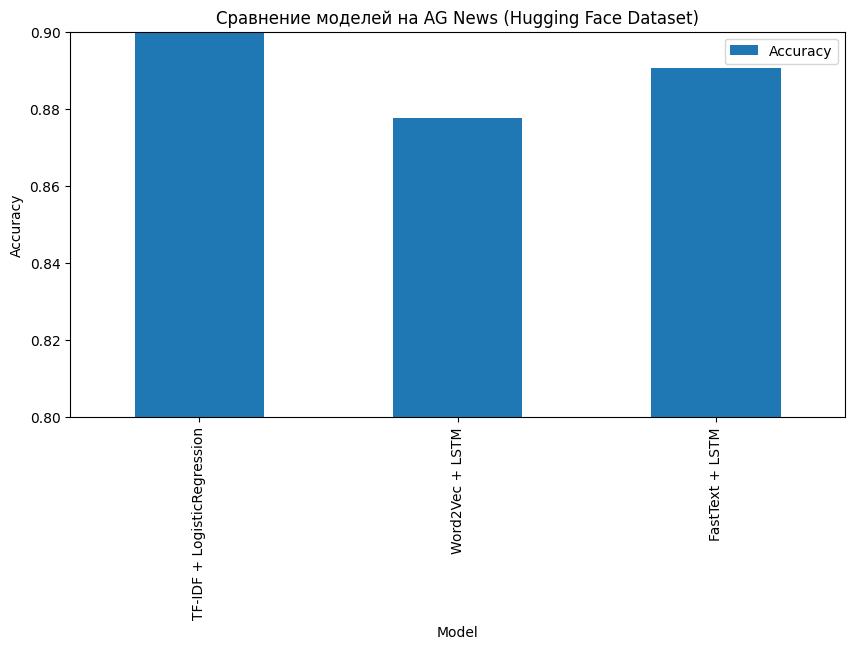

In [10]:
results = {
    "Model": ["TF-IDF + LogisticRegression", "Word2Vec + LSTM", "FastText + LSTM"],
    "Accuracy": [
        np.mean(y_pred_tfidf == y_test),
        np.mean(y_pred_w2v == y_test),
        np.mean(y_pred_ft == y_test)
    ]
}

pd.DataFrame(results).set_index("Model").plot(kind="bar", figsize=(10, 5))
plt.title("Сравнение моделей на AG News (Hugging Face Dataset)")
plt.ylabel("Accuracy")
plt.ylim(0.8, 0.9)
plt.show()